# Introduction

This notebook will look into long-term unemployment. First the data is found on Statistics Denmark, accessed by an API, cleaned and structured and afterwards analyzed briefly. To extend the analysis the dataset is merged with data on gender and unemployment.
First I import the packages that will be used in this notebook:

In [1]:
# import relevant packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd # install with pip install pandas-datareader
import pydst # install with pip install git+https://github.com/elben10/pydst
dst = pydst.Dst(lang = 'en')

# Find Data on Statistics Denmark

Statistics Denmark contains a lot of tables. Therefore it was easier to go to [statisikbanken.dk (bank of statistics)](http://statistikbanken.dk/statbank5a/default.asp?w=1366) and surf around to find some interesting tables. I ended up with the table **AULK10** that contains unemployment after duration and age. In this notebook I will focus on long-term unemployment which is specified later in the code.

Now I have considered what table to look at, I need some lines of code to decide what variables I am interested in.

In [2]:
# see the name of the variables
aulk10 = dst.get_variables(table_id = 'AULK10')
print(aulk10)

# explore the values for 'unit' further to pick only one of them
aulk10.loc[1]['values']

   elimination           id              text   time  \
0        False         KMDR          duration  False   
1        False        ENHED              unit  False   
2         True  YDELSESTYPE  type of benefits  False   
3         True        ALDER               age  False   
4        False          Tid              time   True   

                                              values  
0  [{'id': '026', 'text': '26 weeks'}, {'id': '03...  
1  [{'id': '1', 'text': 'Persons (number)'}, {'id...  
2  [{'id': 'TOT', 'text': 'Total'}, {'id': '01', ...  
3  [{'id': 'TOT', 'text': 'Age, total'}, {'id': '...  
4  [{'id': '2008M07', 'text': '2008M07'}, {'id': ...  


[{'id': '1', 'text': 'Persons (number)'},
 {'id': '4', 'text': 'Persons in pct. of gross unemployed'},
 {'id': '5', 'text': 'Persons per 1,000 in the labour force'}]

The table consists of 5 variables: duration, unit, type of benefits, age and time. I choose to explore duration (grouped), age (grouped) and time. Because I don't want to explore different types of benefits I looked into the values for that variable and will in the next lines of code choose id=1: **persons (number).**

In [3]:
# get the data from dst via an API and save it as 'unemp' 
unemp = dst.get_data(table_id = 'AULK10', variables = {'KMDR': ['*'], 'ENHED': ['1'], 'ALDER': ['*'], 'TID': ['*']})

# see a snip of the data
print(unemp.head(10))

# see the shape of the data
print(f'unemp has shape {unemp.shape}')

       KMDR             ENHED              ALDER      TID YDELSESTYPE  INDHOLD
0  26 weeks  Persons (number)         Age, total  2008M07       Total  23352.0
1  26 weeks  Persons (number)        16-29 years  2008M07       Total   3761.0
2  26 weeks  Persons (number)        30-49 years  2008M07       Total  12171.0
3  26 weeks  Persons (number)  50 years and over  2008M07       Total   7420.0
4  39 weeks  Persons (number)         Age, total  2008M07       Total       ..
5  39 weeks  Persons (number)        16-29 years  2008M07       Total       ..
6  39 weeks  Persons (number)        30-49 years  2008M07       Total       ..
7  39 weeks  Persons (number)  50 years and over  2008M07       Total       ..
8  52 weeks  Persons (number)         Age, total  2008M07       Total       ..
9  52 weeks  Persons (number)        16-29 years  2008M07       Total       ..
unemp has shape (3500, 6)


# Cleaning and Structuring of Data

The dataset needs to be cleaned and restructured before I can do analysis on it. First I drop the columns that are the same for all observations. After each cleaning step I look at a snip and the shape of the dataset to see what happened.

In [4]:
# drop the columns 'enhed' and 'ydelsestype' as they are the same for all observations
unemp.drop(['ENHED','YDELSESTYPE'], axis = 1, inplace = True)

# status after this
print(unemp.head(10))
print(f'unemp has shape {unemp.shape}')

       KMDR              ALDER      TID  INDHOLD
0  26 weeks         Age, total  2008M07  23352.0
1  26 weeks        16-29 years  2008M07   3761.0
2  26 weeks        30-49 years  2008M07  12171.0
3  26 weeks  50 years and over  2008M07   7420.0
4  39 weeks         Age, total  2008M07       ..
5  39 weeks        16-29 years  2008M07       ..
6  39 weeks        30-49 years  2008M07       ..
7  39 weeks  50 years and over  2008M07       ..
8  52 weeks         Age, total  2008M07       ..
9  52 weeks        16-29 years  2008M07       ..
unemp has shape (3500, 4)


This step left the number of rows unchanged but decreased the number of columns from 6 to 4. Now we want to change the names of the variables (columns).

In [5]:
# change the name of the columns by a dictionary
columns_dict = {}
columns_dict['KMDR'] = 'duration' # in weeks
columns_dict['ALDER'] = 'age' # age groups and total
columns_dict['TID'] = 'month'
columns_dict['INDHOLD'] = 'n_persons' # number of persons

unemp.rename(columns = columns_dict, inplace = True)
print(unemp.head(10))

   duration                age    month n_persons
0  26 weeks         Age, total  2008M07   23352.0
1  26 weeks        16-29 years  2008M07    3761.0
2  26 weeks        30-49 years  2008M07   12171.0
3  26 weeks  50 years and over  2008M07    7420.0
4  39 weeks         Age, total  2008M07        ..
5  39 weeks        16-29 years  2008M07        ..
6  39 weeks        30-49 years  2008M07        ..
7  39 weeks  50 years and over  2008M07        ..
8  52 weeks         Age, total  2008M07        ..
9  52 weeks        16-29 years  2008M07        ..


The shape is unchanged and therefore not shown. Next up is to delete missings and change the datatypes. As the code below shows all of the variables are loaded as objects (strings), I need to make them more appropriate to do the analysis and the last cleaning.
In this table Statistics Denmark named some observations '..' which is missings or too insecure to be shown. These are deleted.

In [6]:
# a. drop rows where n_persons='..' (missings)
unemp = unemp[unemp.n_persons != '..'] 

# b. see the initial dataypes
print(unemp.dtypes)

# c. change type of n_persons and duration to integers 
unemp.n_persons = unemp.n_persons.astype(str).str[:-2] # isolate to the whole number of persons (drop ',0')
unemp.n_persons = unemp.n_persons.astype(int) # convert n_persons to integer
unemp.duration = unemp.duration.astype(str).str[:-6] # isolate the actual duration (drop ' weeks') 
unemp.duration = unemp.duration.astype(int) # convert duration to integer

# d. take copy for later use
unemp_copy = unemp.copy()

# e. create date from month
unemp['d'] = (unemp.month.astype(str).str[:4] # grab the year (first four digits)
          + '/' # add /
          + unemp.month.astype(str).str[-2:]) # grab the month (last two digits)
unemp['date'] = pd.to_datetime(unemp.d, format = '%Y/%m')
unemp.drop(['month', 'd'], axis = 1, inplace = True) # drop month and intermediate variable, d 

# f. check new types and shape
print(unemp.dtypes)
print(unemp.head(5))
print(f'unemp has shape {unemp.shape}')

duration     object
age          object
month        object
n_persons    object
dtype: object
duration              int32
age                  object
n_persons             int32
date         datetime64[ns]
dtype: object
    duration                age  n_persons       date
0         26         Age, total      23352 2008-07-01
1         26        16-29 years       3761 2008-07-01
2         26        30-49 years      12171 2008-07-01
3         26  50 years and over       7420 2008-07-01
28        26         Age, total      22433 2008-08-01
unemp has shape (3128, 4)


The cleaning of missing values reduces the number of rows. In the documentation of the table Statistics Denmark defines long-term unemployment as a duration of 52 weeks or more. I will only consider the long-term unemployment.

In [7]:
# restrict the dataset to duration >= 52
unemp = unemp.loc[unemp['duration'] >= 52]

# reset index
unemp.reset_index(inplace = True)
unemp.drop(['index'], axis = 1, inplace = True) # delete the old index

# see a snippet and the shape of the data
print(unemp.head(5))
print(f'unemp has shape {unemp.shape}')

   duration                age  n_persons       date
0        52         Age, total      10690 2009-01-01
1        52        16-29 years       1329 2009-01-01
2        52        30-49 years       5572 2009-01-01
3        52  50 years and over       3789 2009-01-01
4        52         Age, total      10600 2009-02-01
unemp has shape (2140, 4)


# Analysis

## Descriptive Statics: Table and Static Figure with Mean

Now the data is structured and cleaned and I begin the brief analysis. First I group the data both after age and duration. The descriptive statistic is then the **variation over time in the number of persons for each age-group and duration-group.**

In [8]:
# descriptive statics grouped by the age-groups and duration describes the data across time
unemp.groupby(['age', 'duration']).agg(['count','mean','std']).round(1)

n_persons                 
                               count     mean     std
age               duration                           
16-29 years       52             119   3783.7  1163.5
                  78             113   1414.2   572.3
                  104            107    518.2   315.4
                  130            101    216.4   155.6
                  156             95     94.4    71.2
30-49 years       52             119  14200.9  4651.4
                  78             113   7469.9  2694.7
                  104            107   4073.6  1561.4
                  130            101   2392.0   851.9
                  156             95   1464.4   452.7
50 years and over 52             119   8973.4  3085.2
                  78             113   5113.8  1987.0
                  104            107   2921.8  1239.8
                  130            101   1761.5   668.8
                  156             95   1098.6   302.4
Age, total        52             119  26957.9  8743.4
                  78             113  13997.9  5163.5
                  104            107   7513.6  3048.8
                  130            101   4369.9  1615.7
                  156             95   2657.4   775.4

The count is the same for each duration which shows that we have the same number of month-observations for each duration across age-groups. Furthermore we see that each duration have different number of month-observations - this will affect one of the coming graphs.

When looking at the mean we see that the group of 30-49 old is the largest group of long-term unemployed persons and the 16-29 old are the smallest group for all durations. Notice that 'Age, total' is a sum of the 3 age-groups for each duration.

The difference in level make it hard to compare the different age groups. A solution to that problem is to calculate index and look at the development over the months.

But before I will compare the age-groups further I will dive more into the **mean number of persons of the 'Age, total'-group divided in different durations in Figure 1 below.**

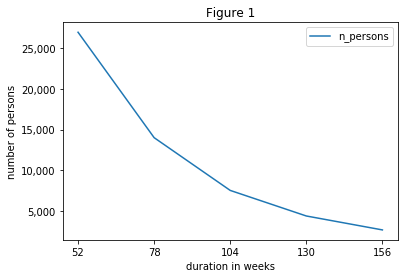

In [9]:
# a. figure with mean of each duration (across months) for total age
mean = unemp.groupby(['age', 'duration']).mean()
mean = mean.loc['Age, total'] # only look at total age

# b. plot for total age
def static_figure():
    
    # i. docstring
    """ Makes a static figure of the mean number of persons of the 'Age, total'-group.
    
    Args: None  
            
    """
    
    # ii. make the plot
    ax = mean['n_persons'].plot(legend = True)
    
    # iii. set thousands separator on y-axis
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    # iv. set x-axis to the number of weeks according to duration
    ax.set_xticks([52, 78, 104, 130, 156])
    
    # v. set labels
    ax.set_ylabel('number of persons')
    ax.set_xlabel('duration in weeks')
    
    # vi. set title
    ax.set_title('Figure 1')

# c. call the function
static_figure()

Not surprising the higher duration the lower number of people are unemployed. From the graph (and the descriptive table above) we see that the number of persons (on average across months) drops by more than 10,000 when looking at a duration of 78 weeks (1.5 year) relative to 52 weeks (1 year).

## Descriptive Statics: Interactive Figure with Indices

Now I dive more into the comparison between the age-groups. This is done with indices which is calculated by 

\\[
\begin{eqnarray*}
index & = & \frac{value_t}{value_0}*100
\end{eqnarray*}\\]

where 0 defines the basis-month. Here I will use the first available month as basis.

In [10]:
# a. make copy
unemp2 = unemp.copy()

# b. sort
unemp2.sort_values(by = ['date', 'duration'], inplace = True)
unemp2.reset_index(inplace = True)
unemp2.drop(['index'], axis = 1, inplace = True) # delete the old index

# c. select the first element in a series
def first(x): 
    return x.iloc[0]

# d. group the data and calcualte the index
grouped = unemp2.groupby(['duration', 'age'])
unemp2['cal_index'] = grouped['n_persons'].transform(lambda x: x/first(x)*100)

# e. set index = date to the figure (run only once!)
unemp2.set_index('date', inplace = True)

# f. check the dataset
unemp2.head(10)

,duration,age,n_persons,cal_index
date,,,,
2009-01-01,52,"Age, total",10690,100.000000
2009-01-01,52,16-29 years,1329,100.000000
2009-01-01,52,30-49 years,5572,100.000000
2009-01-01,52,50 years and over,3789,100.000000
2009-02-01,52,"Age, total",10600,99.158092
2009-02-01,52,16-29 years,1315,98.946576
2009-02-01,52,30-49 years,5554,99.676956
2009-02-01,52,50 years and over,3731,98.469253
2009-03-01,52,"Age, total",10736,100.430309


In the next lines of code I make an **interactive figure with the calculated indices over time** where you can choose which duration you want to look at.

In [11]:
# a. plot that is used to the interactive figure
def interactive_figure(x = 52):
    
    # i. docstring
    """ Makes an interactive figure of the calcualted indices over time.
    
    Args: x : int
        Duration.
            
    """
    
    # ii. make the plot
    I = unemp2.duration == x # plots only if duration = x (argument)
    unemp2[I].groupby(['age'])['cal_index'].plot(legend = True) 
    
    # iii. set labels
    plt.xlabel('Year')
    start_index = unemp2.loc[(unemp2['cal_index'] == 100.0) & (unemp2['duration'] == x)].index # find the basis-month
    start_index2 = min(start_index) # as there is a month for each age-group we just select one of them (they are the same)
    plt.ylabel(f'Index (100 = {start_index2.date()})') # an interactive y-label that shows the basis-month
    
    # iv. set title
    plt.title('Figure 2')

# b. print values for duration to use in the dropdown
unemp2.duration.unique()

# c. dropdown with durations
widgets.interact(interactive_figure,
    x = widgets.Dropdown(description = '$duration$', options = [52, 78, 104, 130, 156])
)

interactive(children=(Dropdown(description='$duration$', options=(52, 78, 104, 130, 156), value=52), Output())…

<function __main__.interactive_figure(x=52)>

Figure 2 shows the development in long-term unemployment across age-groups and for different durations. It is seen e.g. for a duration of 104 weeks that the unemployment rises a lot from 2010-2012. From 2013 it starts to decrease and the group of 50+ years decreases fastest. Despite this the group of 16-29 year olds is at the lowest level relative to the basis-month in 2018, even lower than the level in the basis-month. Notice that the basis-month is showed on the y-axis and adjust for each duration.

# Long-term Unemployment and Gender

To extend the analysis a bit I will examine how the long-term unemployment looks for each gender. In this part I only look at duration = 52 weeks, age total and the first month in the year. Firstly I prepare a version of the unemp-dataset to be merged with a gender-dataset. Then the gender-dataset is read from excel and prepared for merge. Afterwards the datasets are merged and plottet.

In [12]:
# a. select the relevant rows based on the selection described above
unemp3 = unemp_copy.copy()
unemp3 = unemp3.loc[unemp3['duration'] == 52] # only duration = 52
unemp3 = unemp3.loc[unemp3['age'] == 'Age, total'] # only age, total
unemp3['m'] = unemp3.month.astype(str).str[-2:] # isolate the month
unemp3 = unemp3.loc[unemp3['m'] == '01'] # select only the first month each year

# b. create new column with year and set it to int
unemp3['year'] = unemp3.month.astype(str).str[:4]
unemp3.year = unemp3.year.astype(int)

# c. delete irrelevant columns
unemp3.drop(['duration', 'age', 'month', 'm'], axis = 1, inplace = True)

# d. see a snippet of the data
unemp3.head(10)

,n_persons,year
176,10690,2009
512,25239,2010
848,41527,2011
1184,38985,2012
1520,35939,2013
1856,30748,2014
2192,26317,2015
2528,22861,2016
2864,18847,2017
3200,20521,2018


The gender-dataset is downloaded from 'statistikbanken.dk' table AULK09. The interesting variable is the percentage, which is the share of long-term unemployed relative to the total number of unemployed in the month splitted on gender.

In [13]:
# a. import the downloaded dataset
gender = pd.DataFrame()
gender = pd.read_excel('AULK09.xlsx', skiprows=2, nrows=2)

# b. clean dataset: drop irrelevant columns and rename one interesting
gender.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2'], axis = 1, inplace = True)
gender.rename(columns = {'Unnamed: 3':'gender01'}, inplace = True)

# c. keep only columns that ends with 01 as we are only interested in the first months and gender
gender = gender.loc[:, gender.columns.str.endswith('01')]

# d. rename columns to prepare for reshaping the data
mydict = {str(i)+'M01': f'percent{i}' for i in range(2009,2019)}
gender.rename(columns = mydict, inplace=True)

# e. convert to long format 
gender_l = pd.wide_to_long(gender, stubnames='percent', i='gender01', j='year').reset_index()

# f. see a snippet of the data
gender_l.head()

,gender01,year,percent
0,Mænd,2009,6.2
1,Kvinder,2009,9.4
2,Mænd,2010,11.1
3,Kvinder,2010,11.6
4,Mænd,2011,19.2


Now the datasets are ready for merge. I use a left join as gender contains more rows than unemp3 because it is splitted into genders.

In [14]:
# merge n_persons on gender with left join
merged = pd.merge(gender_l, unemp3, on = 'year', how = 'left')

# set index equal to year
merged.set_index('year', inplace = True)

# see a snippet of the data
merged.head()

,gender01,percent,n_persons
year,,,
2009,Mænd,6.2,10690
2009,Kvinder,9.4,10690
2010,Mænd,11.1,25239
2010,Kvinder,11.6,25239
2011,Mænd,19.2,41527


The merged dataset is actually splitted so each gender get it's own column (wide format) because I want to use it in a bar-graph. The graph becomes messy if using the groupby statement on the long-formatted dataframe. A line-graph could easily have been made directly on the merged dataset with groupby.

<Figure size 432x288 with 0 Axes>

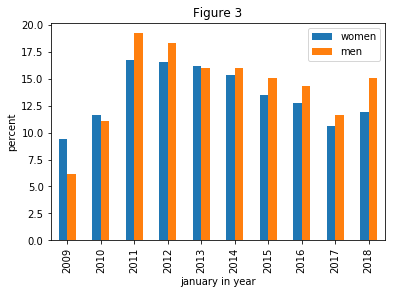

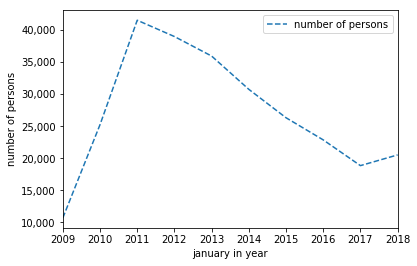

In [15]:
# a. create a new dataframe with genders at each columns (wide format)
df = pd.DataFrame({'women': merged.loc[merged['gender01'] == 'Kvinder']['percent']})
df['men'] = merged.loc[merged['gender01'] == 'Mænd']['percent']

# b. plot the percentage in bar-plot
fig = plt.figure()
ax = df.plot(kind = 'bar')
ax.set_ylabel('percent')
ax.set_xlabel('january in year')
ax.set_title('Figure 3')

# c. plot the total number of unemployed with duration = 52 in line-plot
fig2 = plt.figure()
ay = merged.loc[merged['gender01'] == 'Kvinder']['n_persons'].plot(legend = True, linestyle = 'dashed', 
                                                              label = 'number of persons')
ay.set_ylabel('number of persons')
ay.set_xlabel('january in year')

# d. set x-axis so they are the same for the two plots
ay.set_xlim(2009, 2018)

# e. format y-axis with thousands seperator
ay.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

From the plots we see at all years after 2010 men has a larger share of long-term unemployed relative to all unemployed men. But it is only slightly larger than the share for women. When comparing the graphs we see that both the total number of unemployed and the share of long-term unemployed increases in the years 2009-2011. This reflects both that more people become unemployed => the share of long-term unemployed decreases and the already unemployed doesn't get out of unemployment and more people become long-term unemployed.

# Conclusion

The notebook examines long-term unemployment both across age-groups, durations and gender. It is showed that the number of persons is decreasing in durations in Figure 1. Figure 2 is an interactive graph that allows the reader to pick the desired duration and compare the development in unemployment over time between different age-groups. For the duration of 104 weeks it was seen that the unemployment decreases fast from 2013 for the 50+ aged. Over time the young group reaches the lowest level of unemployment relative to the basis-month (index = 100). At last it was showed in figure 3 that men in most years have a sligthly higher share of long-term unemployed relative to gross unemployment than women.